# Psuedo Ancestry Painting

In [1]:
# Import packages.
import analysis_functions as af
import allel
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': True,
    'axes.spines.right': True,
})
# Intialize the pandas preferences.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load the meta data file for the TGP.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)

In [4]:
# Load the genotype matrix.
tgp_72kb_gt, tgp_72kb_pos = af.load_hap_region('tgp_mod_arc_anc', 12, 40758000, 40830000)
# Polarize the genotype matrix.
tgp_72kb_p_gt = af.polarize_gt(tgp_72kb_gt)

In [5]:
# Calculate the derived allele frequencies for the younger neanderthals.
cha_der_freqs = af.calc_alt_freqs(tgp_72kb_p_gt.take([2348], axis=1))
vin_der_freqs = af.calc_alt_freqs(tgp_72kb_p_gt.take([2349], axis=1))
# Find the site indicies for the heterozygous positions.
cha_het_idx = np.where(cha_der_freqs == 0.5)[0]
vin_het_idx = np.where(vin_der_freqs == 0.5)[0]
# Find all heterozygous sites indicies between the younger neanderthals.
cha_vin_het_idx = np.union1d(cha_het_idx, vin_het_idx)
# Subset the polarized genotype matrix.
tgp_72kb_het_p_gt = tgp_72kb_p_gt.take(cha_vin_het_idx, axis=0)
# Subset the het sites.
cha_vin_het_pos = tgp_72kb_pos[cha_vin_het_idx]

In [6]:
# Build dictionaries for pap analyses.
pap_idx_dicc = {
    'ARC': [
        np.array([2347]), np.array([2348]),
        np.array([2349]), np.array([2350]),
    ],
    'HUM': [
        tgp_df[tgp_df['IND'] == 'NA19190'].index.values, np.array([2348]),
        np.array([2349]), tgp_df[tgp_df['IND'] == 'NA19664'].index.values,
    ],
}
pap_sites_dicc = {'CHA': [], 'VIN': []}
pap_dicc = {}
pap_df_dicc = {
    'Source 1': [
        'DEN', 'DEN',
        'MXL', 'MXL',
    ],
    'Source 2': [
        'ALT', 'ALT', 
        'YRI', 'YRI',
    ],
    'Target': [
        'CHA', 'VIN',
        'CHA', 'VIN',
    ],
    'Total Sites': [
        cha_het_idx.size, vin_het_idx.size,
        cha_het_idx.size, vin_het_idx.size,
    ],
    'PAP Sites': [],
    'PAP Score': [],
}
# For every pap comparison...
for key in pap_idx_dicc.keys():
    # Unpack the indicies.
    s1_idx, cha_idx, vin_idx, s2_idx = pap_idx_dicc[key]
    # Perform the pap analyses.
    p_idx_cha, c_idx_cha = af.psuedo_ancestry_painting(
        tgp_72kb_het_p_gt,
        cha_idx, s1_idx, s2_idx,
    )
    p_idx_vin, c_idx_vin = af.psuedo_ancestry_painting(
        tgp_72kb_het_p_gt,
        vin_idx, s1_idx, s2_idx,
    )
    # Fill the pap-site indicies.
    pap_sites_dicc['CHA'].append(p_idx_cha)
    pap_sites_dicc['VIN'].append(p_idx_vin)
    # Determine the indicies are non pap sites for either younger neanderthal.
    non_pap_mask = np.union1d(c_idx_cha, c_idx_vin)
    # Extract the derived allele frequncey matrix for plotting.
    plot_mat = np.array([
        af.calc_alt_freqs(tgp_72kb_het_p_gt.take(s1_idx, axis=1)),
        af.calc_alt_freqs(tgp_72kb_het_p_gt.take([2348], axis=1)),
        af.calc_alt_freqs(tgp_72kb_het_p_gt.take([2349], axis=1)),
        af.calc_alt_freqs(tgp_72kb_het_p_gt.take(s2_idx, axis=1)),
    ])
    # Mask the sites that couldn't be painted.
    plot_mat[0][non_pap_mask] = -0.5
    plot_mat[-1][non_pap_mask] = -0.5
    # Fill the dictionary.
    pap_dicc[key] = plot_mat
    pap_df_dicc['PAP Sites'].append(p_idx_cha.size)
    pap_df_dicc['PAP Sites'].append(p_idx_vin.size)
    pap_df_dicc['PAP Score'].append(p_idx_cha.size/cha_het_idx.size)
    pap_df_dicc['PAP Score'].append(p_idx_vin.size/vin_het_idx.size)
# Convert to a pandas dataframe.
pap_df = pd.DataFrame(data=pap_df_dicc)
# Export the dataframe.
#pap_df.to_csv(f'./dataframes/pap_scores_72kb.csv', index=False)

In [7]:
# Show the pap results.
pap_df

,Source 1,Source 2,Target,Total Sites,PAP Sites,PAP Score
0,DEN,ALT,CHA,181,158,0.872928
1,DEN,ALT,VIN,180,159,0.883333
2,MXL,YRI,CHA,181,169,0.933702
3,MXL,YRI,VIN,180,168,0.933333


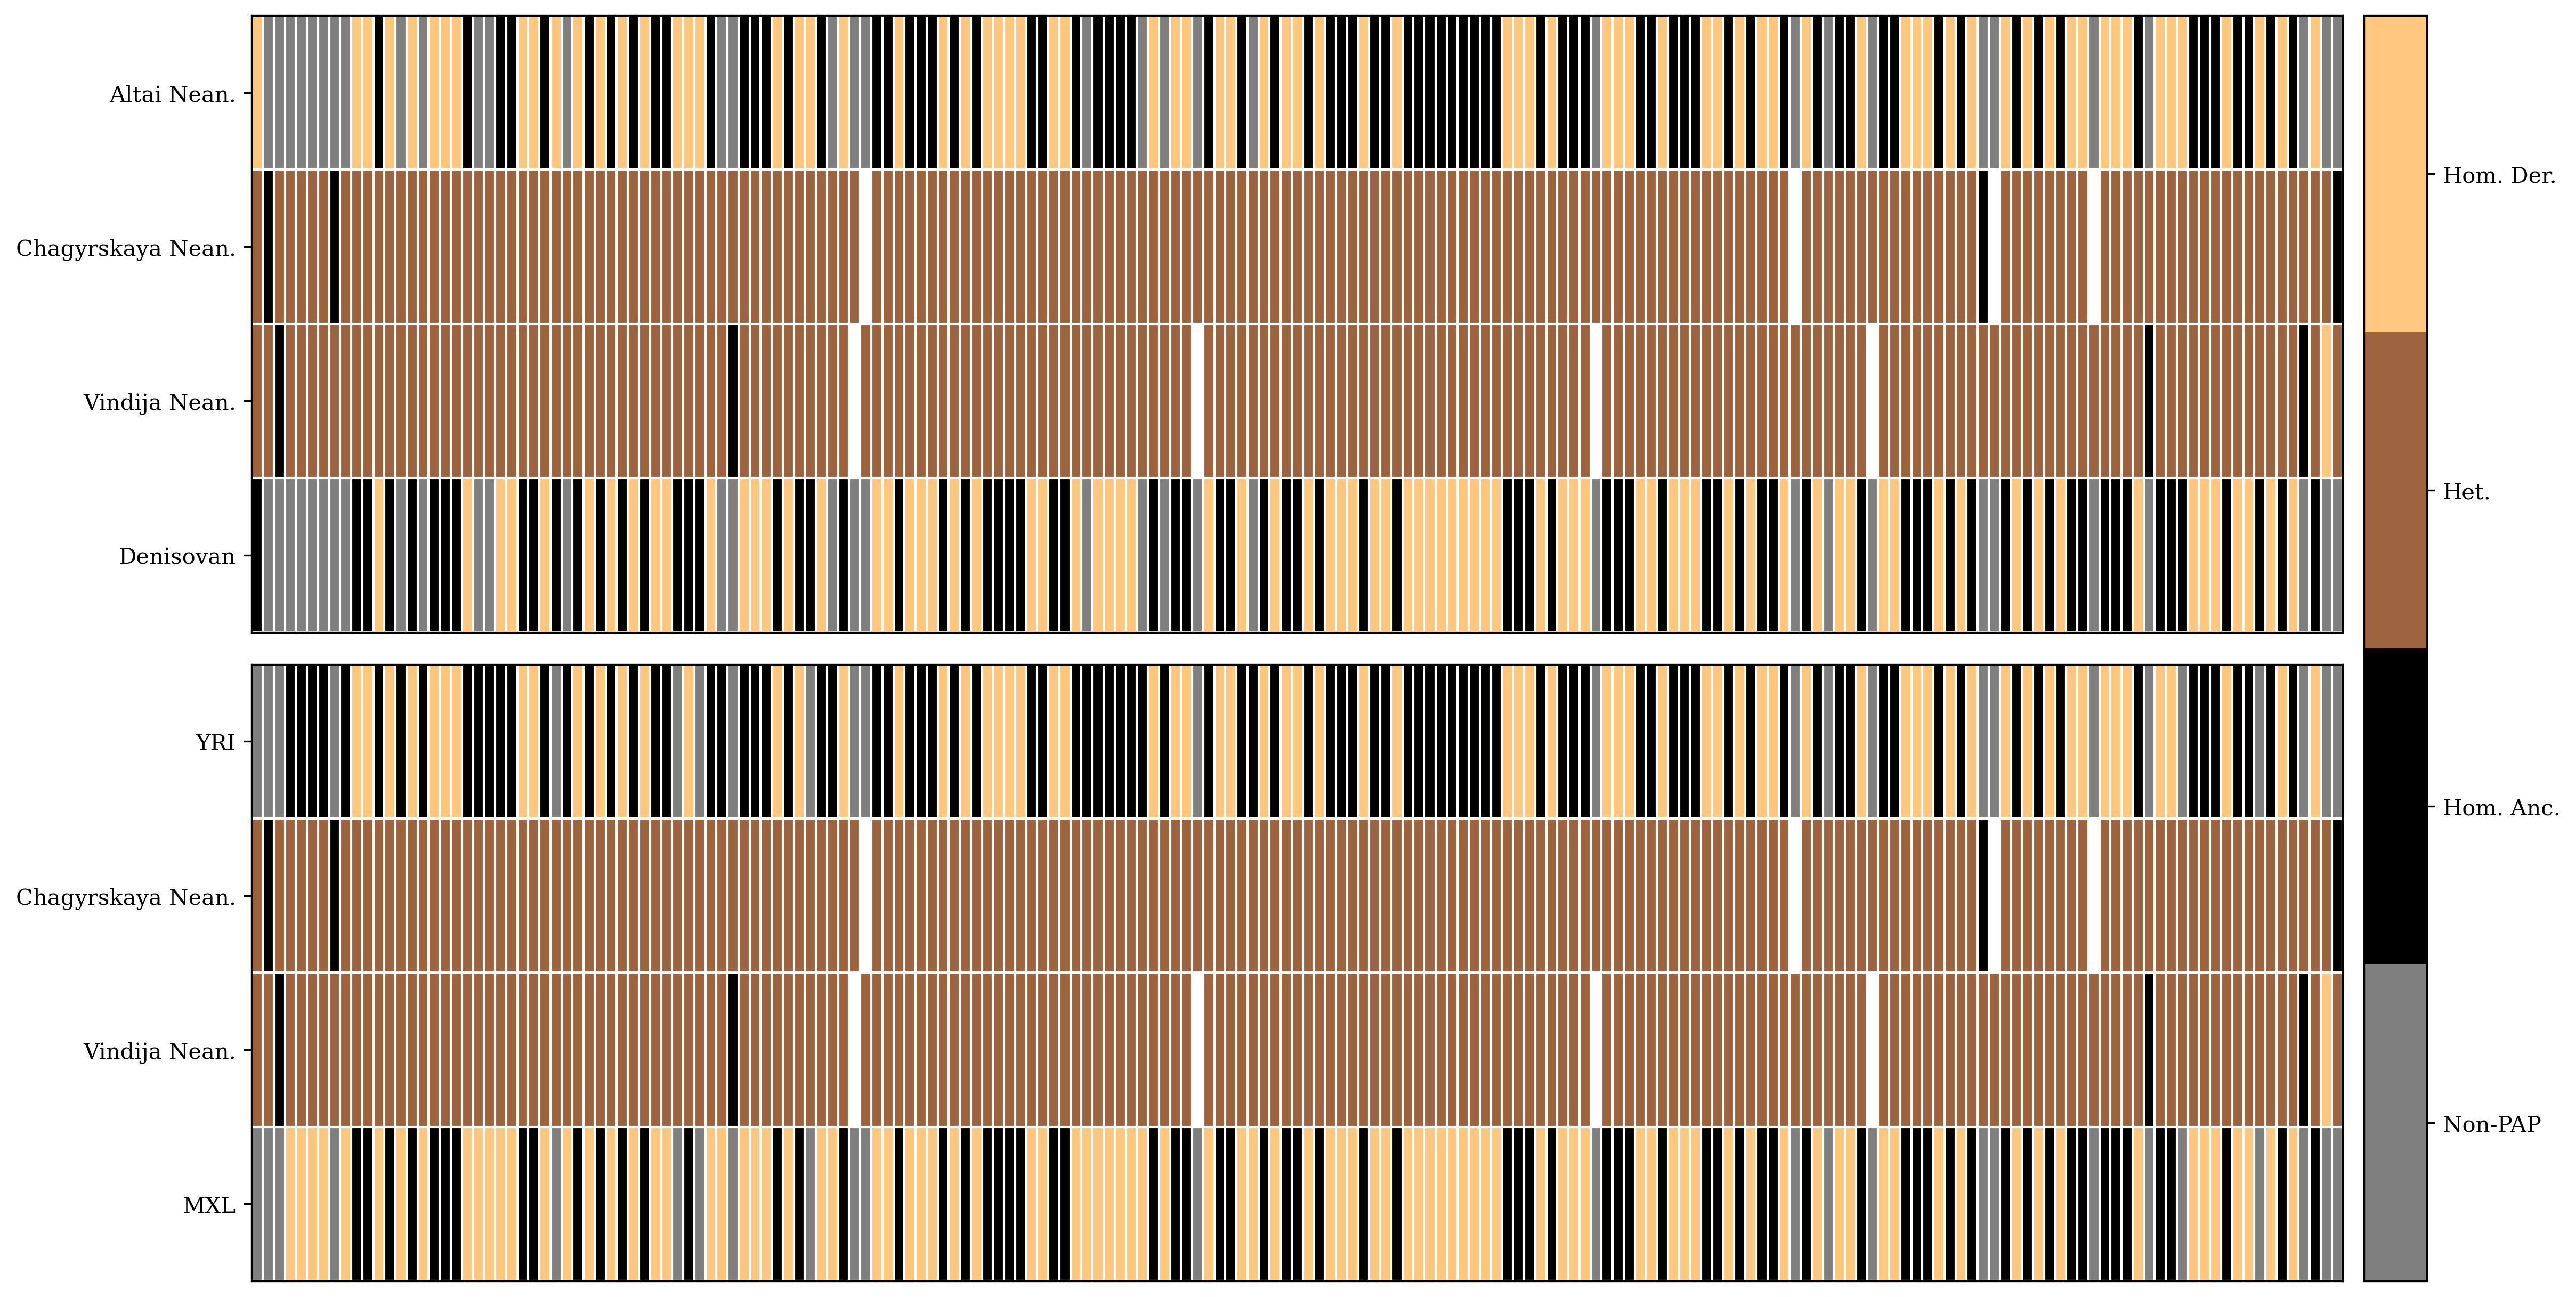

In [8]:
# Intialize an ordered dictionary for plotting.
plot_dicc = {
    'ARC': [
        'Altai Nean.', 'Chagyrskaya Nean.',
        'Vindija Nean.', 'Denisovan',
    ],
    'HUM': [
        'YRI', 'Chagyrskaya Nean.',
        'Vindija Nean.', 'MXL',
    ],
}
# Intialize the figure and axes.
fig, axes = plt.subplots(
    2, 1, figsize=(16, 8), dpi=300,
    sharex=True, sharey=False,
    gridspec_kw={
        'height_ratios': [4, 4],
        'wspace': 0.05, 'hspace': 0.05,
    },
)
# Intialize color map.
cmap = mcolors.LinearSegmentedColormap.from_list(
    None, 
    ['tab:gray', (0.0, 0.0, 0.0, 1.0), (0.6176469134948439, 0.3906, 0.24875, 1.0), (1.0, 0.7812, 0.4975, 1.0)],
)
# Intialize the bounds for the color map.
bounds = np.linspace(-0.5, 1, 5)
# Intialzie the cmap and bounds normalization.
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Intialize a list of keys.
key_list = list(plot_dicc.keys())
# For every key...
for i in range(len(key_list)):
    # Extract the key.
    key = key_list[i]
    # Plot the heatmap.
    im = axes[i].imshow(
        pap_dicc[key], cmap=cmap,
        norm=norm, aspect='auto',
    )
    # Seperate each box.
    axes[i].set_xticks(np.arange(0, tgp_72kb_het_p_gt.shape[0], 1))
    axes[i].set_yticks(np.arange(0, len(plot_dicc[key]), 1))
    axes[i].set_xticks(
        np.arange(-0.5, tgp_72kb_het_p_gt.shape[0], 1), minor=True,
    )
    axes[i].set_yticks(
        np.arange(-0.5, len(plot_dicc[key]), 1), minor=True,
    )
    axes[i].grid(which='minor', color='w', linestyle='-', linewidth=1)
    # Set the y-ticks for each plot.
    axes[i].set_yticks(
        np.arange(len(plot_dicc[key])),
        labels=plot_dicc[key], size=10,
    )
    # Despine.
    axes[i].tick_params(
        which='minor', left=False,
        bottom=False, labelbottom=False,
    )
    axes[i].tick_params(bottom=False, labelbottom=False)
# Intialize the positions for the colobar.
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), pad=0.01,
    ticks=[(bounds[idx] + bounds[idx+1])/2 for idx in range(bounds.size - 1)],
)
# Annotate the colobar.
cbar.ax.set_yticklabels(['Non-PAP', 'Hom. Anc.', 'Het.', 'Hom. Der.'], size=10)
# Export the plot.
# plt.savefig(
#     f'./supp_figures/pap_map_72kb.png', format='png',
#     facecolor='white', bbox_inches='tight', dpi=500,
# )
# Show the plot.
plt.show()